In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow import keras
from tensorflow.keras.layers import *
from datetime import datetime
from tensorflow.keras.applications.inception_v3 import preprocess_input
import albumentations as A
import tensorflow as tf

In [3]:
from os import listdir
from os.path import isfile
from enum import Enum
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
import numpy as np
import math
import albumentations as A
import random

Dataset = Enum("Dataset", "carabid")

# directories to load each of the three datasets
directories = {Dataset.carabid: "/kaggle/input/insect-identification-from-habitus-images/database"}

# number of classes in each dataset
class_num = {Dataset.carabid: 291}


def num_classes(dataset):
    return class_num[dataset]

class EnsembleAugGenerator(keras.utils.Sequence):
    """
    Keras generator which creates inputs for a model by creating a grey-augmented and 
    blur-augmented copies from a single original image.
    Inputs are formatted to work with the ensemble_aug_classifier model.
    """
    def __init__(self, dataset_names, batch_size, filenames):
        self.filenames = filenames
        self.batchsize = batch_size
        self.dataset_names = dataset_names

        self.gray_aug = A.Compose([A.ToGray(p=1.0)])
        self.blur_aug = A.Compose([A.Blur(p=1.0)])

        self._filter_files()
        self.shuffle()

    def _filter_files(self):
        filtered_names = [name.replace("\\", "/") for name in self.dataset_names]
        filtered_filenames = {}
        for category, files in self.filenames.items():
            filtered_filenames[category] = [file for file in files if file in filtered_names]
        self.filenames = filtered_filenames
    
    def _create_augment_array(self, images):
        return [np.array([preprocess_input(img) for img in images]), np.array([preprocess_input(self.gray_aug(image=img)["image"]) for img in images]), 
                np.array([preprocess_input(self.blur_aug(image=img)["image"]) for img in images])]

    def __len__(self):
        return math.ceil(len(self.x) / self.batchsize)

    def names_at_batch(self, idx):
        x_names = self.x[idx * self.batchsize:(idx + 1) * self.batchsize]
        y_names = np.asarray(self.y[idx * self.batchsize:(idx + 1) * self.batchsize])
        return x_names, y_names

    def __getitem__(self, idx):
        x_names = self.x[idx * self.batchsize:(idx + 1) * self.batchsize]
        y_names = np.asarray(self.y[idx * self.batchsize:(idx + 1) * self.batchsize])
        result = self._create_augment_array([np.asarray(img_to_array(load_img(file_name[0], target_size=(299, 299))), dtype='uint8') for file_name in x_names])
        return result, y_names

    def shuffle(self):
        groups = []
        for category, files in self.filenames.items():
            subgroup = []
            for file in files:
                subgroup.append(file)
                groups.append((subgroup, category))
                subgroup = []

        random.shuffle(groups)
        self.x = np.asarray([group[0] for group in groups])
        self.y = np.asarray([group[1] for group in groups])

    def num_classes(self):
        return len(self.filenames)


def get_filenames(dataset):
    """
    Retrieves all filenames of images from a selected dataset and returns them along
    with an array of their associated classes.
    """
    x = []
    y = []
    directory = directories[dataset]
    category_num = 0
    
    for category in listdir(directory):
        if isfile(category):
            continue

        for file in listdir("{0}/{1}".format(directory, category)):
            if file[-4:] not in [".jpg", "jpeg", ".png", ".gif"]:
                continue
            x.append("{0}/{1}/{2}".format(directory, category, file))
            y.append(category_num)
        category_num += 1
    return x, y


def make_image_dict(x, y):
    """
    Makes a dictionary in which all keys are the names of a dataset's labels and
    all entries are a list of image filenames associated with the key's label.
    """
    names = {}
    for i in range(len(x)):
       files = names.get(y[i], []) 
       files.append(x[i])
       names[y[i]] = files
    return names


def do_nothing(image):
    """
    Default augment option: does not augment an image in any way.
    """
    return {"image": image}


def prep_ensemble_aug_dataset(dataset, keras_train_dataset, keras_val_dataset, batch_size):
    """
    Prepares a train and validation set for a ensemble_aug_classifier model.
    """
    filenames = make_image_dict(*get_filenames(dataset))
    train_gen = EnsembleAugGenerator(keras_train_dataset.file_paths, batch_size, filenames)
    val_gen = EnsembleAugGenerator(keras_val_dataset.file_paths, batch_size, filenames)
    return train_gen, val_gen

def prep_dataset(dataset, batch_size):
    """
    Prepares a basic train and validation set for a model.
    """
    train = keras.preprocessing.image_dataset_from_directory(directories[dataset], batch_size=batch_size, image_size=(299, 299), seed=42, validation_split=0.15, subset='training')
    val = keras.preprocessing.image_dataset_from_directory(directories[dataset], batch_size=batch_size, image_size=(299, 299), seed=42, validation_split=0.15, subset='validation')
    return train, val

def prep_test_dataset(dataset, batch_size):
    """
    Prepares a test set for a model.
    """
    test = keras.preprocessing.image_dataset_from_directory(
        directories[dataset], 
        batch_size=batch_size, 
        image_size=(299, 299)
    )
    return test

def prep_ensemble_aug_test_dataset(dataset, keras_test_dataset, batch_size):
    """
    Prepares a test set for a ensemble_aug_classifier model.
    """
    filenames = make_image_dict(*get_filenames(dataset))
    test = EnsembleAugGenerator(keras_test_dataset.file_paths, batch_size, filenames)
    return test

Found 63364 files belonging to 291 classes.
Using 53860 files for training.
Found 63364 files belonging to 291 classes.
Using 9504 files for validation.


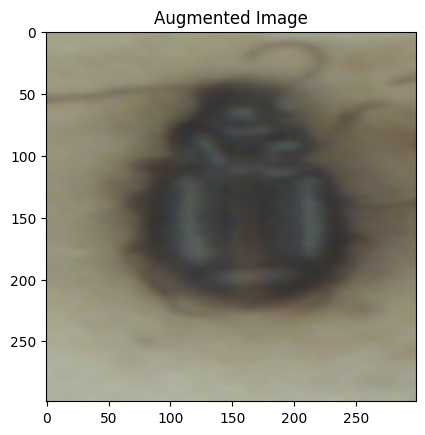

In [7]:
import matplotlib.pyplot as plt
dataset = Dataset.carabid
dataset_name = str(dataset).split(".")[1]
current_time = datetime.now().strftime("%d%m%Y-%H%M%S")

augment = A.Compose([A.Blur(p=1.0)])

def apply_aug(images):
    aug_imgs = []
    for img in images:
        aug_imgs.append(augment(image=img)["image"])
    return np.array(aug_imgs)

def process_data(images, labels):
    aug_imgs = tf.numpy_function(apply_aug, [images], tf.float32)
    return aug_imgs/255, labels

raw_train, raw_val = prep_dataset(dataset, 8)
extractor_train = raw_train.map(process_data)
extractor_val = raw_val.map(process_data)


for images, labels in extractor_train.take(1):
    plt.figure()
    plt.imshow(images.numpy()[0])  # 显示第一张图像
    plt.title("Augmented Image")
    plt.show()

Found 63364 files belonging to 291 classes.
Using 53860 files for training.
Found 63364 files belonging to 291 classes.
Using 9504 files for validation.


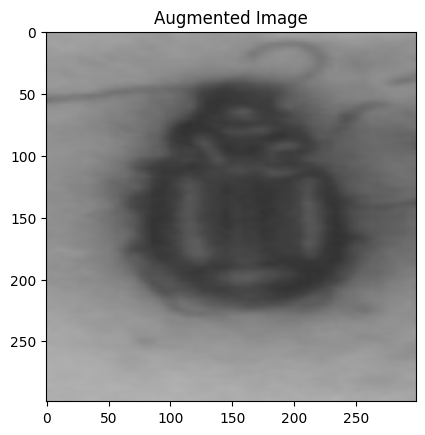

In [8]:
import matplotlib.pyplot as plt
dataset = Dataset.carabid
dataset_name = str(dataset).split(".")[1]
current_time = datetime.now().strftime("%d%m%Y-%H%M%S")

augment = A.Compose([A.ToGray(p=1.0)])

def apply_aug(images):
    aug_imgs = []
    for img in images:
        aug_imgs.append(augment(image=img)["image"])
    return np.array(aug_imgs)

def process_data(images, labels):
    aug_imgs = tf.numpy_function(apply_aug, [images], tf.float32)
    return aug_imgs/255, labels

raw_train, raw_val = prep_dataset(dataset, 8)
extractor_train = raw_train.map(process_data)
extractor_val = raw_val.map(process_data)


for images, labels in extractor_train.take(1):
    plt.figure()
    plt.imshow(images.numpy()[0])
    plt.title("Augmented Image")
    plt.show()